# <center>Training a Decentralized Machine Learning Model</center>

In this phase, we will train a decentralized machine learning (ML) model using Horizontal Federated Learning (HFL), where five clients collaboratively train a model on fraud transaction data without sharing their raw data. Each client retains its dataset locally, and only model updates are exchanged, ensuring privacy and compliance with data protection regulations.

Unlike centralized ML, where data is aggregated in a single location, HFL addresses privacy concerns, data silos, and regulatory constraints**. After benchmarking the centralized model, we will compare its performance, efficiency, and trade-offs against the federated approach to assess its viability in fraud detection.

--- 

In [1]:
%load_ext autoreload
%load_ext watermark
    
%autoreload 2
%watermark --python -p torch,flwr

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.32.0

torch: 2.6.0
flwr : 1.14.0



--------

## Loading Dependencies

In [2]:
import os
import sys
sys.path.append("../")

import ray 
import torch
import torch.nn as nn

from logging import ERROR

from flwr.common import ndarrays_to_parameters, Context 
from flwr.client import Client, ClientApp, NumPyClient
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg 
from flwr.simulation import run_simulation 

from src.config import NUM_CLASSES, NUM_FEATURES, SERVER_CONFIG
from src.train_decentralized import train_model
from src.FL_client import BankFLClient
from src.FL_server import weighted_average, evaluate 
from src.local_utility import load_client_data, load_test_data, get_weights, set_weights
from src.local_utility import set_device, set_seed

------

In [3]:
DEVICE = set_device()
set_seed()

In [4]:
# Load Datasets
num_clients = SERVER_CONFIG['num_clients']
train_sets = []
val_sets = []

for i in range(num_clients):
    train_set, val_set = load_client_data(i)
    train_sets.append(train_set)
    val_sets.append(val_set)

test_set = load_test_data()

------

In [5]:
# Define Model 

class FraudDetectionModel(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = nn.Sequential(

            # 1st hidden layer
            nn.Linear(num_features, 25),
            nn.ReLU(),

            # 2nd hidden layer
            nn.Linear(25, 15),
            nn.ReLU(),

            # output layer
            nn.Linear(15, num_classes)
        )

    def forward(self, x):
        logits = self.all_layers(x)
        return logits

----

In [6]:
def client_fn(context: Context) -> Client:
    """
    Creates and initializes a federated learning client.

    This function initializes a client in the federated learning setup by 
    assigning a unique partitioned dataset and a machine learning model 
    for training and validation.

    Args:
        context (Context): The execution context containing client-specific configurations.

    Returns:
        Client: A configured federated learning client ready to participate in training.
    """
    partition_id = int(context.node_config["partition-id"]) #<--- Get the client partition ID
    model = FraudDetectionModel(num_features=NUM_FEATURES, num_classes=NUM_CLASSES) # initialize model
    client_train = train_sets[partition_id] #<-- Assign partitioned training dataset
    client_val = val_sets[partition_id]     #<-- Assign partitioned validation dataset
    
    return BankFLClient(model, client_train, client_val).to_client()

client = ClientApp(client_fn)

In [7]:
model = FraudDetectionModel(num_features=NUM_FEATURES, num_classes=NUM_CLASSES)
params = ndarrays_to_parameters(get_weights(model))

def server_fn(context: Context):
    """
    Creates and configures the federated learning server using the FedAvg strategy.

    This function initializes the federated learning server with a FedAvg strategy,
    specifying the parameters for client participation in training and evaluation,
    the global model evaluation function, and the metric aggregation function.

    Args:
        context (Context): The execution context for the federated learning server.

    Returns:
        ServerAppComponents: A configured server application with the defined strategy
        and server settings.
    """
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,                 #<--- Sample 100% of available clients for training
        fraction_evaluate=1.0,            #<--- Sample 100% of available clients for evaluation
        initial_parameters=params,        #<--- Initial model parameters
        evaluate_fn=evaluate,             #<--- Global evaluation function
        evaluate_metrics_aggregation_fn=weighted_average,  #<-- pass the metric aggregation function
    )

    # Configure the server with the specified number of federated rounds
    sever_config = ServerConfig(num_rounds=SERVER_CONFIG['num_rounds']) #<--- no. of federated rounds
    
    return ServerAppComponents(strategy = strategy, config = sever_config)


# Wrap the server function in a ServerApp, and instantiate it
server = ServerApp(server_fn = server_fn) 

----- 

Set up our backend configurations before running the simulation

> - `init_args`: filter logging coming from the Simulation Engine so it's more readable in notebooks
> - `client_resources`: by default, allocate to each client 1x CPU and 0x GPUs. However, when running on GPU, assign an entire GPU for each client

In [8]:
backend_setup = {
    "init_args": {
        "logging_level": ERROR, 
        "log_to_driver": False
    },
    "client_resources": {
        "num_cpus": 1, 
        "num_gpus": 0.0
    },
}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda": 
    backend_setup["client_resources"] = {"num_cpus": 1, "num_gpus": 1.0}

--- 

## Initiate the Simulation 

Initiate the simulation by passing the server and client apps, and specify the number of supernodes that will be selected on every round. 

2025-02-08 07:16:22,385	INFO worker.py:1752 -- Started a local Ray instance.
2025-02-08 07:16:25,784	INFO packaging.py:530 -- Creating a file package for local directory 'C:\Users\Emeka Obiefuna\Desktop\Data Science\Personal Projects\MLC - Research Work\MLC-FedML'.
2025-02-08 07:16:26,340	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_289d5286d7cec99b.zip' (16.97MiB) to Ray cluster...
2025-02-08 07:16:26,503	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_289d5286d7cec99b.zip'.
INFO :      Starting Flower ServerApp, config: num_rounds=20, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      initial parameters (loss, other metrics): 0.7135769834323805, {'accuracy': 0.3485881207400195}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO :      aggregate_fit: recei


Accuracy: 0.81 | Recall: 0.72 | Precision: 0.74 | ROC-AUC: 0.86

 ___________________________________________________________________________________________________ 



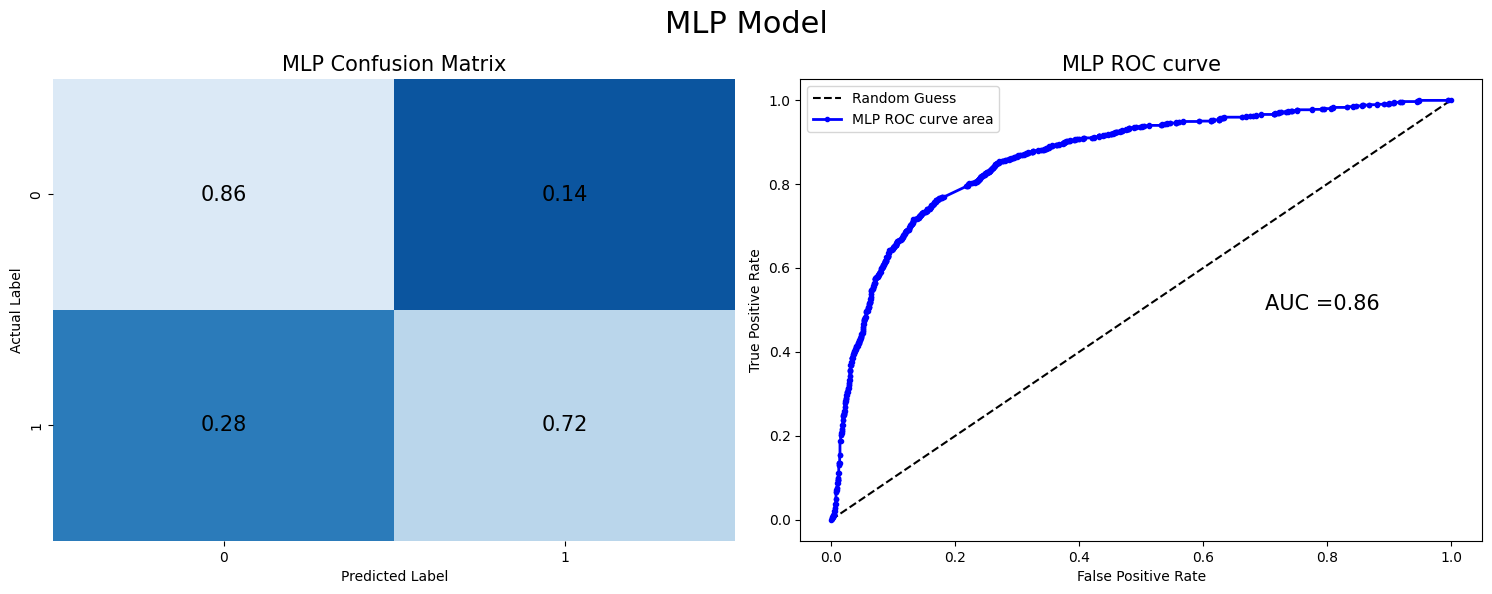

INFO :      fit progress: (20, 0.49844793032626716, {'accuracy': 0.8114248620577734}, 163.68887779999932)
INFO :      configure_evaluate: strategy sampled 5 clients (out of 5)


___________________________________________________________________________________________________ 

Federated Learning Classification Report
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      2007
           1       0.74      0.72      0.73      1074

    accuracy                           0.81      3081
   macro avg       0.79      0.79      0.79      3081
weighted avg       0.81      0.81      0.81      3081

___________________________________________________________________________________________________


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 20 round(s) in 164.17s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.4169192142620699
INFO :      		round 2: 0.40498612191249395
INFO :      		round 3: 0.41213704609391344
INFO :      		round 4: 0.406117086547706
INFO :      		round 5: 0.408292114331028
INFO :      		round 6: 0.4068950409140635
INFO :      		round 7: 0.4138558380636844
INFO :      		round 8: 0.42028717024063517
INFO :      		round 9: 0.43294963793155206
INFO :      		round 10: 0.43304809558471347
INFO :      		round 11: 0.4296450820716522
INFO :      		round 12: 0.4408484915691666
INFO :      		round 13: 0.4381648384008661
INFO :      		round 14: 0.43914485153739413
INFO :      		round 15: 0.442790773147554
INFO :      		round 16: 0.44700602124114397
INFO :      		round 17: 0.4577978342710628
INFO :      		round 18: 0.4490816234591757
INFO :      		round 19: 0.46245155456347

In [9]:
project_root =  os.path.abspath("..") 
ray.init(runtime_env={"working_dir": project_root})

run_simulation(
    server_app = server,
    client_app = client,
    num_supernodes = SERVER_CONFIG.get("num_clients"), #<-- number of clients (5)
    backend_config=backend_setup
)